In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime
import numpy as np
from scipy import stats
import seaborn as sns
import warnings
import dash
from dash import dcc, html, Input, Output, dash_table
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from jupyter_dash import JupyterDash

# Загрузка данных

In [3]:

# Загружаем собранные данные
warnings.filterwarnings('ignore')
def parse_price_history(history_str):
    """Парсинг строки с историей цен"""
    try:
        history = json.loads(history_str.replace("'", '"'))
        return [{
            'dt': datetime.utcfromtimestamp(item['dt']),
            'price': item['price']['RUB'] / 100  # Перевод в рубли
        } for item in history]
    except:
        return None

# Загрузка данных
df = pd.read_csv('../data/wildberries_data_all.csv', converters={"История_цен": parse_price_history, "Текущая_цена": lambda x: int("".join(x[:-1].split()))})
df = df[~df.index.duplicated(keep='first')]

# Очистка данных и подготовка к анализу

In [4]:
df.head(10)


,Название,Артикул,Текущая_цена,История_цен
0,/ Джинсы багги широкие бойфренды,337372659,3585,"[{'dt': 2025-03-16 00:00:00, 'price': 4187.31}..."
1,/ Футболка Премиум однотонная демисезон,239615941,1016,"[{'dt': 2025-02-02 00:00:00, 'price': 1083.18}..."
2,/ Льняная рубашка оверсайз подростковая с капю...,296832458,1469,"[{'dt': 2025-03-23 00:00:00, 'price': 2322.5},..."
3,/ Лонгслив хлопковый,175142976,502,"[{'dt': 2025-02-02 00:00:00, 'price': 607.0}, ..."
4,/ Костюм с шортами детский летний муслин,363457687,1927,"[{'dt': 2025-04-13 00:00:00, 'price': 1945.0},..."
5,/ Джинсы джеггинсы скинни с высокой посадкой,314294759,1524,"[{'dt': 2025-03-02 00:00:00, 'price': 1691.89}..."
6,/ Костюм трикотажный шорты с футболкой,155189814,1549,"[{'dt': 2025-02-02 00:00:00, 'price': 1757.9},..."
7,/ Велосипедки,159196166,258,"[{'dt': 2025-02-02 00:00:00, 'price': 342.27},..."
8,/ Костюм летний детский футболка шорты в садик,212106873,1317,"[{'dt': 2025-02-16 00:00:00, 'price': 1688.33}..."
9,/ Платье летнее леопардовое большие размеры,167573167,1434,"[{'dt': 2025-02-02 00:00:00, 'price': 945.0}, ..."


--- Результаты Андерсона-Дарлинга ---
Статистика: 309.02
Критические значения:
15.0%: 0.58
10.0%: 0.66
5.0%: 0.79
2.5%: 0.92
1.0%: 1.09


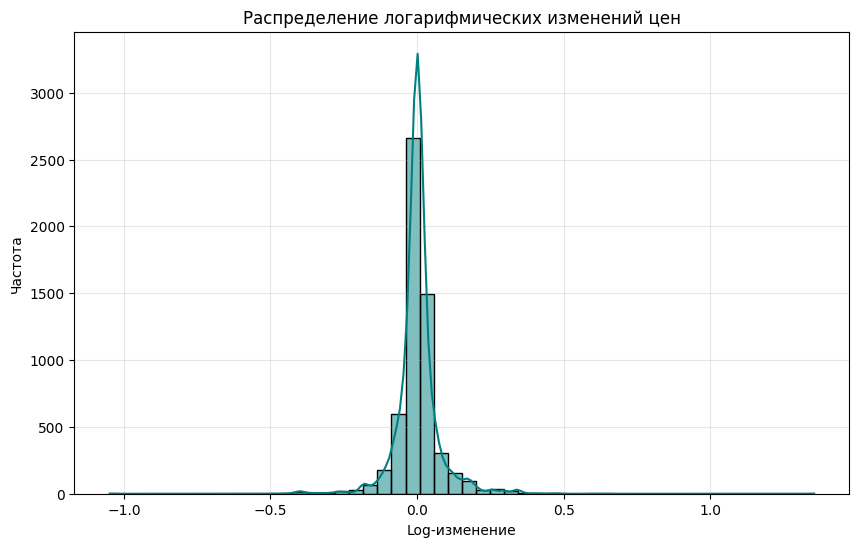

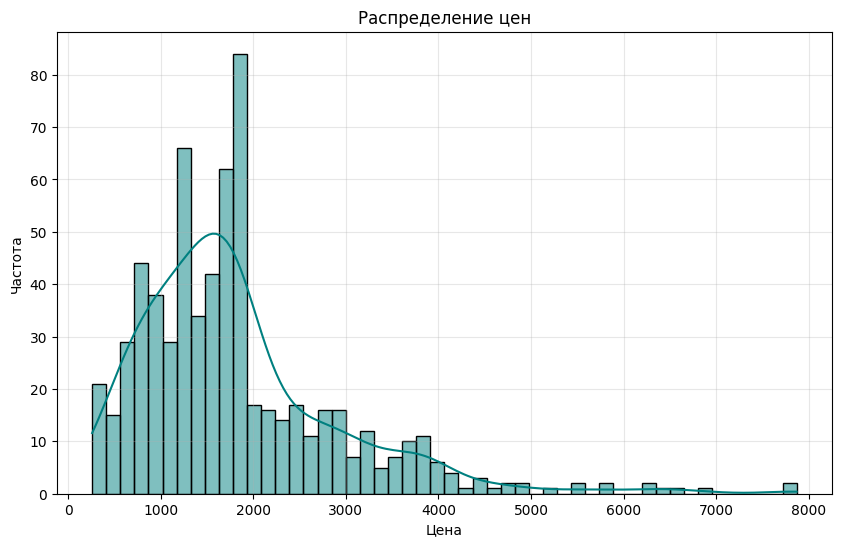

In [5]:
def analyze_distribution(df):
    """Анализ распределения изменения цены"""
    # Сбор всех логарифмических изменений
    all_returns = []
    for _, row in df.iterrows():
        history = pd.DataFrame(row['История_цен'])
        history['log_return'] = np.log(history['price']/history['price'].shift(1))
        all_returns.extend(history['log_return'].dropna().tolist())
    
    # Проведение теста
    ad_result = stats.anderson(all_returns)
    print("--- Результаты Андерсона-Дарлинга ---")
    print(f"Статистика: {ad_result.statistic:.2f}")
    print("Критические значения:")
    for sl, cv in zip(ad_result.significance_level, ad_result.critical_values):
        print(f"{sl}%: {cv:.2f}")
    
    # Визуализация распределения изменения цены
    plt.figure(figsize=(10,6))
    sns.histplot(all_returns, kde=True, bins=50, color='teal')
    plt.title('Распределение логарифмических изменений цен')
    plt.xlabel('Log-изменение')
    plt.ylabel('Частота')
    plt.grid(alpha=0.3)
    plt.show()

    # Визуализация распределения цены
    plt.figure(figsize=(10,6))
    sns.histplot(df["Текущая_цена"], kde=True, bins=50, color='teal')
    plt.title('Распределение цен')
    plt.xlabel('Цена')
    plt.ylabel('Частота')
    plt.grid(alpha=0.3)
    plt.show()
analyze_distribution(df)

По результатам теста Андерсона-Дарлинга можно увидеть, что распределение не является нормальным, также по графику видно, что в основном преобладает отсутствие изменения цены, следующим популярным движением является незначительное изменение цены. Рассмотрим эти данные далее

In [7]:
# Анализ двухнедельных изменений цен
def calculate_biweekly_changes(row):
    """Расчет изменений за недельные периоды"""
    history = pd.DataFrame(row['История_цен'])
    history = history.set_index('dt').resample('W').last()
    
    # Добавление текущей цены
    current_data = pd.DataFrame({
        'price_rub': [row['Текущая_цена']],
        'dt': [pd.to_datetime('today').normalize()]
    }).set_index('dt')
    
    full_history = pd.concat([history, current_data])
    full_history['change'] = full_history['price'].pct_change()
    return full_history['change'].dropna()

# Сбор данных
changes_data = []
for idx, row in df.iterrows():
    changes = calculate_biweekly_changes(row)
    for date, change in changes.items():
        changes_data.append({
            'Артикул': row['Артикул'],
            'Период': date,
            'Изменение_цены': change
        })

changes_df = pd.DataFrame(changes_data)




In [8]:
# Этап 5: Восстановление недостающих данных
def restore_missing_prices(row, mean_changes):
    """Восстановление исторических данных с проверкой границ"""
    history = pd.DataFrame(row['История_цен'])
    
    if history.empty:
        return pd.DataFrame()
    
    # Создание полного временного ряда
    full_range = pd.date_range(
        start='2025-01-01',
        end=history['dt'].max(),
        freq='W'
    )
    
    merged = pd.merge(
        pd.DataFrame({'dt': full_range}), 
        history, 
        how='left', 
        on='dt'
    ).sort_values('dt', ascending=False)
    
    # Заполнение пропусков
    merged['price'] = merged['price'].ffill()
    
    # Применение средних изменений 
    for i in range(len(merged) - 1):  
        if pd.isna(merged.iloc[i]['price']):
            period = merged.iloc[i]['dt']
            avg_change = mean_changes.get(period, 0)
            
            # Проверка доступности следующего элемента
            if i + 1 < len(merged):
                merged.iat[i, 1] = merged.iloc[i+1]['price'] * (1 + avg_change)
            else:
                merged.iat[i, 1] = np.nan
    
    return merged.sort_values('dt').dropna()
# Расчет средних изменений
mean_changes = changes_df.groupby('Период')['Изменение_цены'].mean().to_dict()

# Восстановление данных
restored_prices = []
for idx, row in df.iterrows():
    restored = restore_missing_prices(row, mean_changes)
    restored['Артикул'] = row['Артикул']
    restored_prices.append(restored)

full_history_df = pd.concat(restored_prices)

# Анализ и визуализация

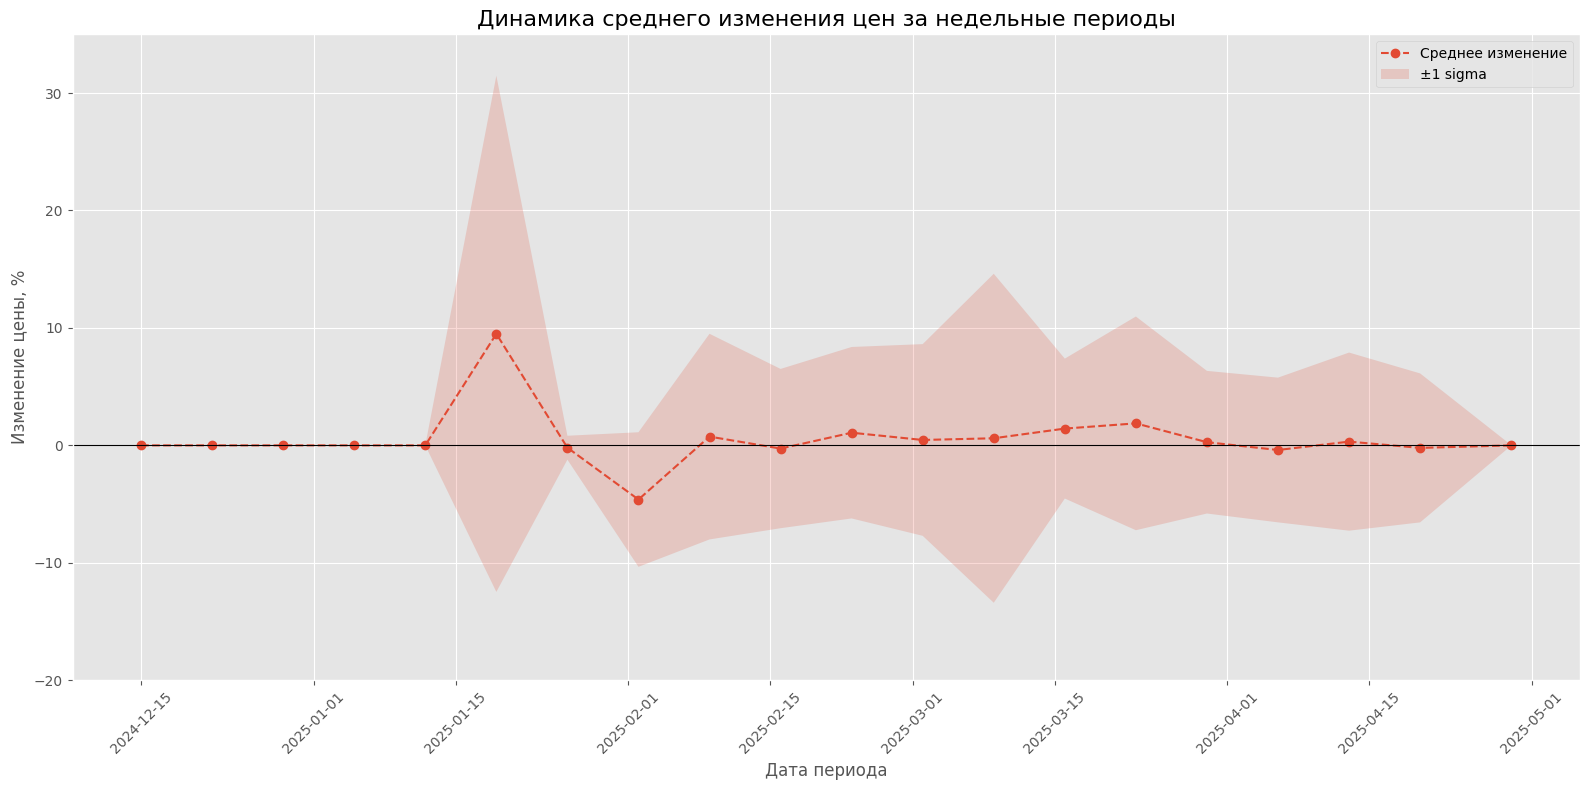

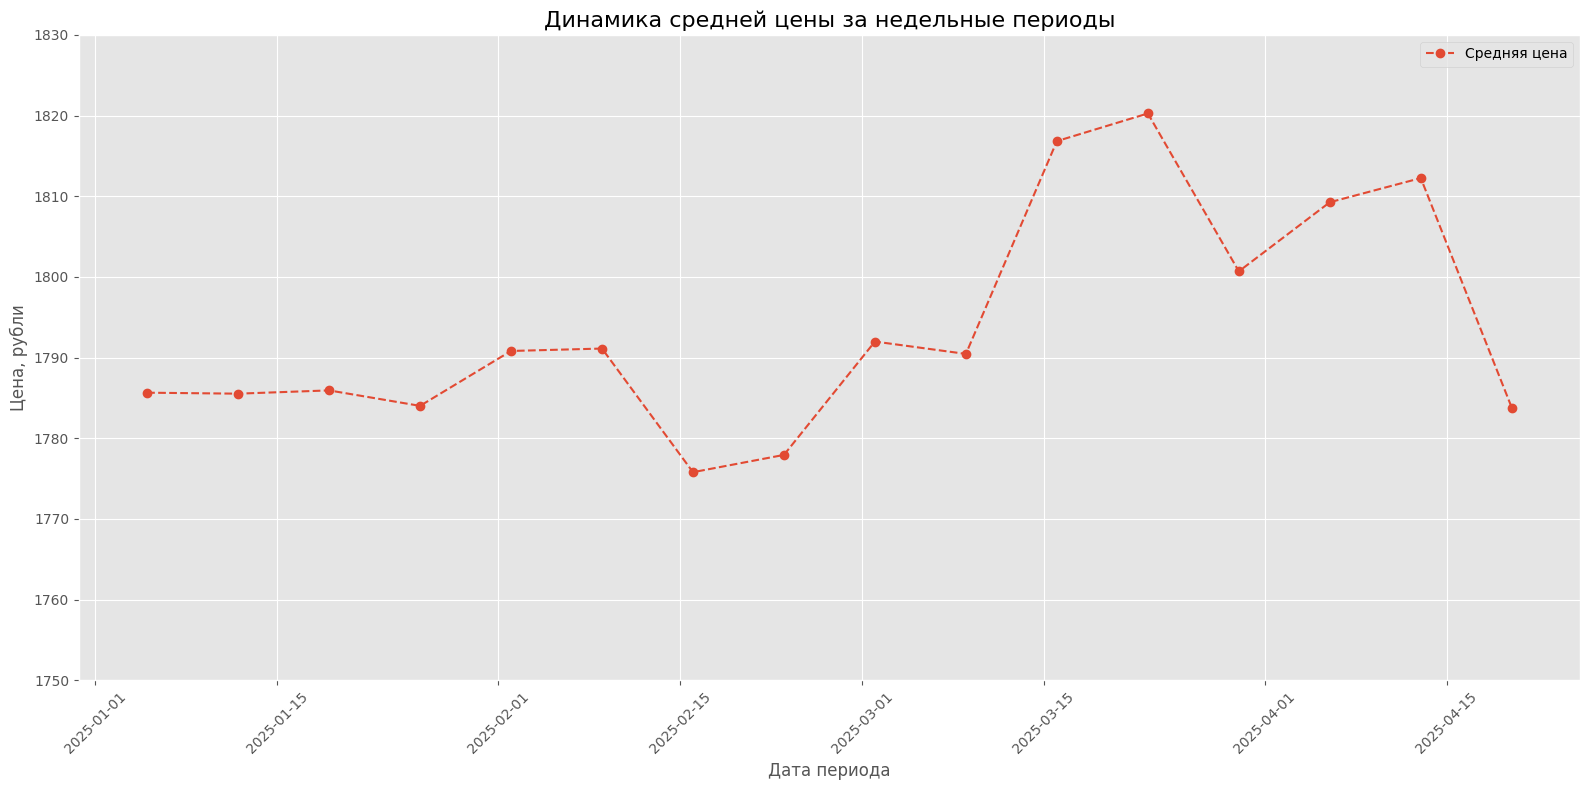

In [9]:
# Этап 6: Визуализация
# График 1 Средние изменения цен
plt.style.use('ggplot')
plt.figure(figsize=(16, 8))
agg_data = changes_df.groupby('Период').agg({
    'Изменение_цены': ['mean', 'std', 'count']
}).reset_index()

plt.plot(agg_data['Период'], 
         agg_data[('Изменение_цены', 'mean')] * 100, 
         marker='o',
         linestyle='--',
         label='Среднее изменение')


plt.fill_between(agg_data['Период'],
                 (agg_data[('Изменение_цены', 'mean')] - 
                  agg_data[('Изменение_цены', 'std')]) * 100,
                 (agg_data[('Изменение_цены', 'mean')] + 
                  agg_data[('Изменение_цены', 'std')]) * 100,
                 alpha=0.2,
                 label='±1 sigma')

plt.title('Динамика среднего изменения цен за недельные периоды', fontsize=16)
plt.xlabel('Дата периода', fontsize=12)
plt.ylabel('Изменение цены, %', fontsize=12)
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.ylim(-20,35)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#График 2: Средняя цена
plt.figure(figsize=(16,8))
agg_data = full_history_df.groupby('dt').agg({
    'price': ['mean', 'std', 'count']
}).reset_index()
plt.plot(agg_data['dt'], 
         agg_data[('price', 'mean')] , 
         marker='o',
         linestyle='--',
         label='Средняя цена')
plt.title('Динамика средней цены за недельные периоды', fontsize=16)
plt.xlabel('Дата периода', fontsize=12)
plt.ylabel('Цена, рубли', fontsize=12)
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.ylim(1750,1830)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Итого мы видим, что на динамику цены приближение сезона влияет непосредственно, но с некоторыми условиями:
#### Под начало сезона повышенного спроса многие клиенты ожидают хороших скидок, а соответственно конкурентноспособны те карточки товаров, которые имеют знак о том, что продавец понизил цену.
#### Для того, чтобы добиться такого эффекта, за несколько недель до подобных тому периодов, продавцы искусственно завышают цену, чтобы потом уже с повышенной цены дать покупателю "скидку"
#### Данный эффект очень хорошо виден на повышении цены и последующем ее снижении в период с 3 января по 22 марта, когда цена резко поднялась, а потом также резко упала.
#### Такой же скачок виден после 15 апреля. Стоит учитывать, что большое кол-во данных минимизирует амплитуду скачков из-за того, что продавцы в разное время снижают и повышают цены, и в конечнем счете некоторые изменения растворяются друг в друге при взятии среднего значения.
###### Дополнительно рассмотрим квадратичное изменение цены для того, чтобы оценить колебание цены перед сезоном в обе стороны.

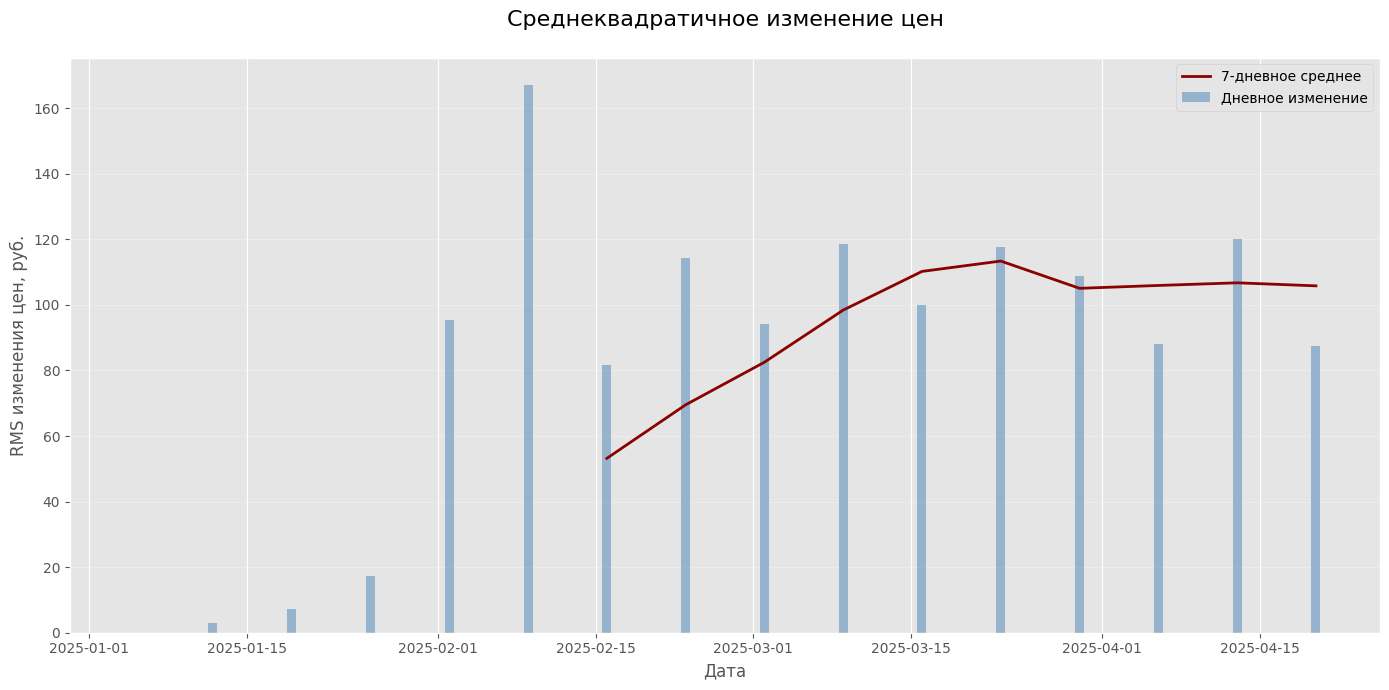

In [10]:
# 7. График среднего квадратичного изменения цен

def calculate_rms_change(full_history_df):
    """Расчет среднеквадратичного изменения цен"""
    # Сортировка данных
    full_history_df = full_history_df.sort_values(['Артикул', 'dt'])
    
    # Расчет изменений цен для каждого товара
    full_history_df['change'] = full_history_df.groupby('Артикул')['price'].diff()
    
    # Удаление первых записей без предыдущего значения
    changes_df = full_history_df.dropna(subset=['change'])
    
    # Группировка по дате и расчет RMS
    rms_data = changes_df.groupby('dt').apply(
        lambda x: np.sqrt(np.sum(x['change']**2) / len(x))
    ).reset_index(name='rms_change')
    
    return rms_data

def plot_rms_change(rms_data, window=7):
    """Визуализация среднеквадратичного изменения"""
    # Сглаживание данных
    rms_data['smooth'] = rms_data['rms_change'].rolling(window).mean()
    
    # Построение графика
    plt.figure(figsize=(14, 7))
    
    # Столбцы изменений
    plt.bar(rms_data['dt'], 
           rms_data['rms_change'], 
           color='steelblue',
           alpha=0.5,
           label='Дневное изменение')
    
    # Линия тренда
    plt.plot(rms_data['dt'], 
            rms_data['smooth'], 
            color='darkred',
            linewidth=2,
            label=f'{window}-дневное среднее')
    
    # Настройки графика
    plt.title('Среднеквадратичное изменение цен\n', fontsize=16)
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('RMS изменения цен, руб.', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.legend()
    
    # Вывод статистики
    max_rms = rms_data['rms_change'].max()
    plt.annotate(f'Максимальное RMS: {max_rms:.2f} руб.', 
                xy=(rms_data['rms_change'].idxmax(), max_rms),
                xytext=(20, -30),
                textcoords='offset points',
                arrowprops=dict(arrowstyle="->"))
    
    plt.tight_layout()
    plt.show()

# Расчет и отрисовка
rms_df = calculate_rms_change(full_history_df)
plot_rms_change(rms_df)

На графике отчетливо видно, что, при приближении к летнему сезону, RMS постоянно растет, из чего можно сделать конечный вывод.

# Выводы
### На основании полученных данных можно однозначно сказать, что
#### 1. При приближении сезона цены начинают колебаться активнее (растет волатильность цен)
#### 2. Для того, чтобы вписываться в сезонные распродажи WB, перед началом сезона продавцы искусственно завышают цены на товары, с которых уже дают скидку из чего складывается РЕАЛЬНОЕ изменение цены +6-10%
#### 3. Уже после наступления сезона динамика цен ослабевает


# Обсуждение
Благодаря этому анализу мы увидели, чем именно обусловлена динамика цены товара в околосезонный и сезонный периоды. В будущем исследование можно улучшить путем использования не только одежды в датасете, но и других сезонных товаров, а также рассмотреть, как динамика проявляет себя уже после окончания сезона. В первую очередь это исследование будет полезно новым продавцам на WB, чтобы понять, когда именно менять цену на свои товары в преддверии каких-то событий, а также в целом рассчитать оптимальную ценовую политику на WB основываясь на анализе ценовой политики конкурентов. 